In [5]:
import sys
import pandas as pd
import numpy as np

sys.path.insert(1, '../../../../scripts/')
from s3_support import *
%matplotlib inline

# Load transactions data for performance indicator

In [6]:
trans = redshift_query_read("select count(id) as count, sum(amount) as volume, org, form, date_trunc('month', date) as month from transactions where status='A' group by org, form, date_trunc('month', date)")

In [7]:
trans_agg = []
for form in trans['form'].unique():
    _trans = trans[trans['form']==form].copy()
    
    _trans.sort_values('month', ascending=True, inplace=True)
    _trans['growth_vol'] = _trans['volume'].diff() / _trans['volume'].shift()
    _trans['growth_count'] = _trans['count'].diff() / _trans['count'].shift()
    
    trans_agg.append({
        'form': form,
        'org': _trans['org'].iloc[0],
        'volume': _trans['growth_vol'].tail(12).mean(),
        'count': _trans['growth_count'].tail(12).mean(),
        'last_12_available': len(_trans.tail(12))
    })

In [8]:
trans_agg = pd.DataFrame(trans_agg)
trans_agg.head()

,count,form,last_12_available,org,volume
0,0.981332,130,12,131,1.010111
1,0.005357,25,12,51,0.077337
2,-0.005556,68,10,94,inf
3,0.689848,48,12,74,2.992490
4,0.103169,54,12,80,1.396589


In [9]:
# dropping forms w/ less than 3 months data
less_than_3_months = len(trans_agg[trans_agg['last_12_available']<=3])

print("{:.2f}% of forms have less than 3 months performance history".format((less_than_3_months / len(trans_agg)) * 100.))
print("{} forms left after dropping those with less than 3 months history".format(len(trans_agg[trans_agg['last_12_available']>3])))

trans_agg = trans_agg[trans_agg['last_12_available']>3]

52.37% of forms have less than 3 months performance history
10502 forms left after dropping those with less than 3 months history


In [10]:
print("System wide means:")
print("Volume: {:.2f}".format(trans_agg['volume'].replace([np.inf, -np.inf], np.nan).dropna().mean()))
print("Count: {:.2f}".format(trans_agg['count'].replace([np.inf, -np.inf], np.nan).dropna().mean()))

System wide means:
Volume: 38.17
Count: 1.72


# Load segment data

## CMS

In [8]:
q = '''select
            users.org as org,
            count(saved_page.id) as page_saves
        from saved_page
            left join users on saved_page.uuid=users.uuid
        group by org'''
org_cms_saves = redshift_query_read(q, schema='secure')

### Look at average growth by orgs that have saved CMS pages and those that have not

In [44]:
cms_active_orgs = org_cms_saves['org'].unique().tolist()

org_growth = trans_agg.groupby('org')[['count', 'volume']].mean().reset_index()
org_growth['org'] = org_growth['org'].astype(int)

print("System wide")
print("\tmean count growth: {:.2f}".format(org_growth['count'].mean()))
print("\tmean volume growth: {:.2f}".format(org_growth['volume'].replace([np.inf, -np.inf], np.nan).dropna().mean()))

print("CMS active orgs")
print("\tmean count growth: {:.2f}".format(org_growth[org_growth['org'].isin(cms_active_orgs)]['count'].replace([np.inf, -np.inf], np.nan).dropna().mean()))
print("\tmean volume growth: {:.2f}".format(org_growth[org_growth['org'].isin(cms_active_orgs)]['volume'].replace([np.inf, -np.inf], np.nan).dropna().mean()))

print("Not CMS active orgs")
print("\tmean count growth: {:.2f}".format(org_growth[~org_growth['org'].isin(cms_active_orgs)]['count'].replace([np.inf, -np.inf], np.nan).dropna().mean()))
print("\tmean volume growth: {:.2f}".format(org_growth[~org_growth['org'].isin(cms_active_orgs)]['volume'].replace([np.inf, -np.inf], np.nan).dropna().mean()))

System wide
	mean count growth: 1.59
	mean volume growth: 55.49
CMS active orgs
	mean count growth: 1.80
	mean volume growth: 60.09
Not CMS active orgs
	mean count growth: 1.24
	mean volume growth: 48.83


We can see here that the average count & volume growth is notably greater within the CMS active organizations. Unfortunately the number of CMS active organizations is insubstantial compared to the population, but the difference seen here makes this datapoint worth looking at for future modeling.

### Look at average growth by CMS page saves

In [16]:
org_growth = trans_agg.groupby('org')[['count', 'volume']].mean().reset_index()

org_growth['org'] = org_growth['org'].fillna(0).astype(int)
org_cms_saves['org'] = org_cms_saves['org'].fillna(0).astype(int)

org_cms_saves = org_cms_saves.merge(org_growth, on="org")

In [18]:
org_cms_saves.tail(3)

,org,page_saves,count,volume
2358,351235,1,-0.038101,0.138286
2359,39936,1,1.156245,2.633445
2360,444185,1,1.386441,4.804086


In [19]:
org_cms_saves[['page_saves', 'count', 'volume']].corr()

,page_saves,count,volume
page_saves,1.000000,-0.003803,0.038424
count,-0.003803,1.000000,0.135725
volume,0.038424,0.135725,1.000000


In [26]:
page_save_avg = []
for v in sorted(org_cms_saves['page_saves'].unique()):
    if v < 24:
        page_save_avg.append({
            'page_saves': str(v),
            'count_growth': org_cms_saves[org_cms_saves['page_saves']==v]['count'].mean(),
            'volume_growth': org_cms_saves[org_cms_saves['page_saves']==v]['volume'].replace([np.inf, -np.inf], np.nan).fillna(1.).mean()
        })

page_save_avg.append({
    'page_saves': '24+',
    'count_growth': org_cms_saves[org_cms_saves['page_saves']>=24]['count'].mean(),
    'volume_growth': org_cms_saves[org_cms_saves['page_saves']>=24]['volume'].replace([np.inf, -np.inf], np.nan).fillna(1.).mean()
})

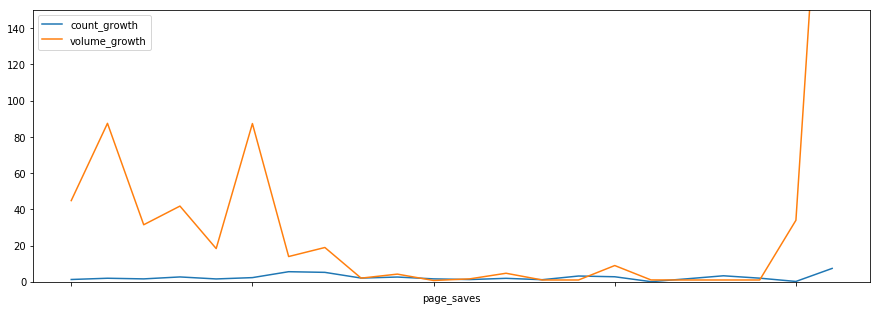

In [31]:
pd.DataFrame(page_save_avg).plot(x='page_saves', ylim=(0,150), figsize=(15,5))

There is a lot of noise here but there does not appear to be a clear relationship between number of pages saved and transaction growth. It does stand to reason that forms that customize their form to better suit their constituents would experience greater growth. Whether this is a sign of a more engaged organization or an actual cause of greater conversion can probably not be clearly determined, but __the evidence remains that organizations that engage with the CMS experience greater growth.__

# Widgets

In [34]:
q = '''select
            users.org as org,
            count(created_widget.id) as widgets
        from created_widget
            left join users on created_widget.uuid=users.uuid
        group by org'''
org_widgets = redshift_query_read(q, schema='secure')

## Comparing growth between organizations with widgets to the population

In [53]:
org_with_widgets = org_widgets['org'].dropna().unique().astype(int).tolist()

org_growth = trans_agg.groupby('org')[['count', 'volume']].mean().reset_index()
org_growth['org'] = org_growth['org'].astype(int)

print("System wide")
print("\tmean count growth: {:.2f}".format(org_growth['count'].mean()))
print("\tmean volume growth: {:.2f}".format(org_growth['volume'].replace([np.inf, -np.inf], np.nan).dropna().mean()))

print("Orgs w/ widgets")
print("\tmean count growth: {:.2f}".format(org_growth[org_growth['org'].isin(org_with_widgets)]['count'].replace([np.inf, -np.inf], np.nan).dropna().mean()))
print("\tmean volume growth: {:.2f}".format(org_growth[org_growth['org'].isin(org_with_widgets)]['volume'].replace([np.inf, -np.inf], np.nan).dropna().mean()))

print("Orgs w/out widgets")
print("\tmean count growth: {:.2f}".format(org_growth[~org_growth['org'].isin(org_with_widgets)]['count'].replace([np.inf, -np.inf], np.nan).dropna().mean()))
print("\tmean volume growth: {:.2f}".format(org_growth[~org_growth['org'].isin(org_with_widgets)]['volume'].replace([np.inf, -np.inf], np.nan).dropna().mean()))

System wide
	mean count growth: 1.59
	mean volume growth: 55.49
Orgs w/ widgets
	mean count growth: 3.60
	mean volume growth: 66.50
Orgs w/out widgets
	mean count growth: 1.42
	mean volume growth: 54.72


Here we another clear sign of greater growth with an engaged organization with __more than twice the mean count growth and nearly 20% greater volume growth for ogranizations with widgets than those without__. This should prove to be a strong predictor.

# Logins

In [11]:
q = '''select
            distinct(users.org) as org
        from login
            left join users on login.user_id=users._id
        where
            login.original_timestamp >= add_months(current_date, -3);'''
org_logins = redshift_query_read(q, schema='secure')

## Comparing growth between organizations with login records to the population

In [13]:
org_with_logins = org_logins['org'].dropna().unique().astype(int).tolist()

org_growth = trans_agg.groupby('org')[['count', 'volume']].mean().reset_index()
org_growth['org'] = org_growth['org'].astype(int)

print("System wide")
print("\tmean count growth: {:.2f}".format(org_growth['count'].mean()))
print("\tmean volume growth: {:.2f}".format(org_growth['volume'].replace([np.inf, -np.inf], np.nan).dropna().mean()))

print("Orgs w/ logins")
print("\tmean count growth: {:.2f}".format(org_growth[org_growth['org'].isin(org_with_logins)]['count'].replace([np.inf, -np.inf], np.nan).dropna().mean()))
print("\tmean volume growth: {:.2f}".format(org_growth[org_growth['org'].isin(org_with_logins)]['volume'].replace([np.inf, -np.inf], np.nan).dropna().mean()))

print("Orgs w/out logins")
print("\tmean count growth: {:.2f}".format(org_growth[~org_growth['org'].isin(org_with_logins)]['count'].replace([np.inf, -np.inf], np.nan).dropna().mean()))
print("\tmean volume growth: {:.2f}".format(org_growth[~org_growth['org'].isin(org_with_logins)]['volume'].replace([np.inf, -np.inf], np.nan).dropna().mean()))

System wide
	mean count growth: 1.56
	mean volume growth: 50.83
Orgs w/ logins
	mean count growth: 1.83
	mean volume growth: 52.59
Orgs w/out logins
	mean count growth: 1.23
	mean volume growth: 48.88
